In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline
import os
import pandas as pd
import json

## 1. Propensity score matching

In [2]:
data = pd.read_csv('lalonde.csv')
data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


Observational study
We have 2 groups: "treated" vs "control"
The question is: was the treatment effective on the worker? That is, did it improved his earnings? did it depend on any of the other variables? (age, origin, marriage, education)
We need a way to measure effectiveness based on change in earnings

treatment assignment: Z = 1 (treated) and Z = 0 (control) -> treat
response if subject is treated: r_t -> how re78 differs from re74 and re75 (Z=1)
response if subject is control: r_c -> how re78 differs from re74 and re75 (Z=0)
observed covariates (features x) -> age, educ, black, hispan, married, nodegree
unobserved covariates ->  Naive model: exclude them because assume “Only observed variables determine treatment assignment”. Bad, naive model is almost never true. -> Use propensity score.
"Adjustments using a model attempt to compare people who are not directly
comparable — people of somewhat different ages or smoking habits — removing
these differences using a mathematical structure that has elements estimated from
the data at hand."


Propensity score -> "if naive model is true, it equals the probability to treat"
e(x) = P(Z=1|x)
Computed by logistic regression. Features x, label Z



In [3]:
# print the shape of the DataFrame
data.shape

(614, 11)

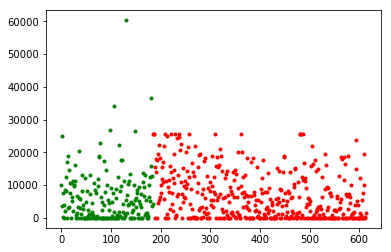

In [4]:
plt.plot(data[data['treat']==1].loc[:,'re78'],'.g')
plt.plot(data[data['treat']==0].loc[:,'re78'],'.r')

In [5]:
data_not_treated = data[data['treat']==0].reset_index().loc[:,'re78']
data_treated = data[data['treat']==1].reset_index().loc[:,'re78']

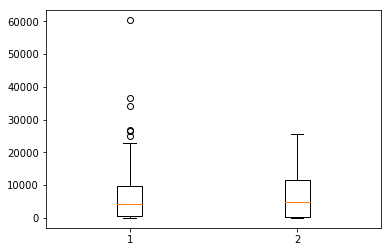

In [6]:
%matplotlib inline
data_to_plot = [data_treated, data_not_treated]
plot = plt.boxplot(data_to_plot)

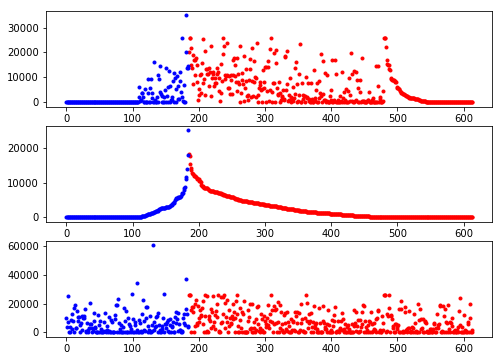

In [7]:
fig = plt.figure(figsize=(8, 6)) 
plt.subplot(3,1,1)
plt.plot(data[data['treat'] == 0].loc[:,'re74'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'re74'],'.b')
plt.subplot(3,1,2)
plt.plot(data[data['treat'] == 0].loc[:,'re75'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'re75'],'.b')
plt.subplot(3,1,3)
plt.plot(data[data['treat'] == 0].loc[:,'re78'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'re78'],'.b')

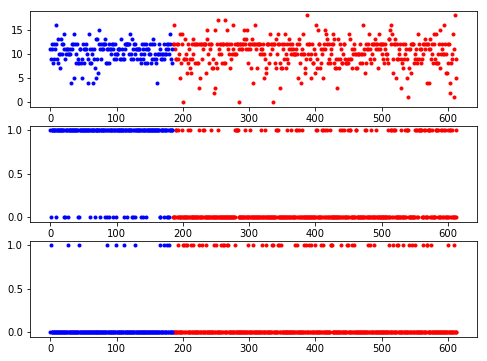

In [8]:
fig = plt.figure(figsize=(8, 6)) 
plt.subplot(3,1,1)
plt.plot(data[data['treat'] == 0].loc[:,'educ'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'educ'],'.b')
plt.subplot(3,1,2)
plt.plot(data[data['treat'] == 0].loc[:,'black'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'black'],'.b')
plt.subplot(3,1,3)
plt.plot(data[data['treat'] == 0].loc[:,'hispan'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'hispan'],'.b')

In [9]:
total_treated = data['treat'].sum()
total_untreated = data['treat'].count() - total_treated

## Race Demographics

In [10]:
# Treated people demographics
total_black_treated = data[data['treat'] == 1].loc[:,'black'].sum()
total_hispanic_treated = data[data['treat'] == 1].loc[:,'hispan'].sum()
total_white_treated = total_treated - (total_black_treated + total_hispanic_treated)

# Unreated people demographics
total_black_untreated = data[data['treat'] == 0].loc[:,'black'].sum()
total_hispanic_untreated = data[data['treat'] == 0].loc[:,'hispan'].sum()
total_white_untreated = total_untreated - (total_black_untreated + total_hispanic_untreated)

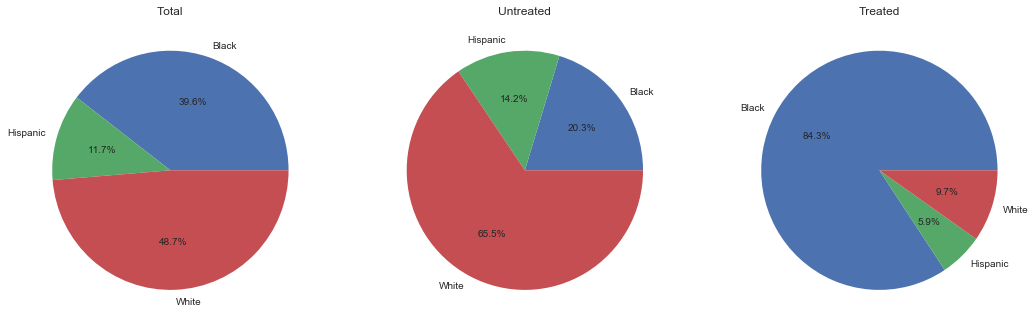

In [13]:
fig = plt.figure(figsize=(18,5.5))
plt.style.use('seaborn')

axes1 = plt.subplot(1,3,1).set_title("Total")
plt.pie([total_black_treated+total_black_untreated,total_hispanic_treated+total_hispanic_untreated,total_white_treated+total_white_untreated],\
        labels=['Black','Hispanic','White'],autopct='%1.1f%%')
plt.title("Total")

axes2 = plt.subplot(1,3,2)
plt.pie([total_black_untreated,total_hispanic_untreated,total_white_untreated],\
        labels=['Black','Hispanic','White'],autopct='%1.1f%%')
plt.title("Untreated")

axes3 = plt.subplot(1,3,3).set_title("Treated")
plt.pie([total_black_treated,total_hispanic_treated,total_white_treated],\
        labels=['Black','Hispanic','White'],autopct='%1.1f%%')
plt.title("Treated")

plt.show()

## Age demographics

In [14]:
# Show age demographics across treated and untreated
data

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899
5,NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940
6,NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000
7,NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580
8,NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220
9,NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.0700
